# **Install PyTorch**





In [ ]:
!pip install -U torch torchvision tqdm lxml

# **Mounting Goodle Drive & Set Path**

In [ ]:
# === Mount google drive ============
from google.colab import drive
drive.mount('/content/drive')

# ===Set path for PASCAL VOC dataset
import os
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset Loader for Pascal VOC**

In [10]:
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import os

class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transforms=None):
        self.root = root
        self.transforms = transforms
        self.image_dir = os.path.join(root, "JPEGImages")
        self.ann_dir = os.path.join(root, "Annotations")

        with open(os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")) as f:
            self.image_ids = [x.strip() for x in f.readlines()]

        self.class_map = {"object": 1, "object_alt": 2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + ".jpg")
        ann_path = os.path.join(self.ann_dir, img_id + ".xml")

        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_xml(ann_path)

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            label = self.class_map.get(name, 1)

            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))

            # Filter invalid boxes: width or height < 1 pixel
            if (xmax - xmin) < 1 or (ymax - ymin) < 1:
                continue

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        if len(boxes) == 0:
            # Add dummy box to avoid crash
            boxes = [[0, 0, 1, 1]]
            labels = [0]  # dummy background label

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return target

# **Load Faster R-CNN and Start Training**

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 3  # background + object + object_alt
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load dataset
transform = T.ToTensor()
train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in tqdm(train_loader):
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


100%|██████████| 626/626 [11:52<00:00,  1.14s/it]


Epoch 1, Loss: 727.0512


100%|██████████| 626/626 [00:56<00:00, 11.14it/s]


Epoch 2, Loss: 682.3641


100%|██████████| 626/626 [00:56<00:00, 11.16it/s]


Epoch 3, Loss: 657.1804


100%|██████████| 626/626 [00:56<00:00, 11.15it/s]


Epoch 4, Loss: 642.6062


100%|██████████| 626/626 [00:56<00:00, 11.10it/s]

Epoch 5, Loss: 633.2674


# **Save Model**

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/sonar-object-detection/sonar_fasterrcnn.pth")

# **visualize_predictions.py**

In [ ]:
import os
import cv2
import torch
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from PIL import Image
# VOCDataset is already available in notebook – no import needed

def visualize(model, dataset_root, num_images=5, image_set="val", confidence_threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset
    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    model.eval()
    model.to(device)

    for i in range(num_images):
        img, _ = dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)[0]

        img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()  # convert to OpenCV format

        for box, score in zip(output["boxes"], output["scores"]):
            if score < confidence_threshold:
                continue
            x1, y1, x2, y2 = box.int().tolist()
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))  # convert back for display
        plt.axis("off")
        plt.show()

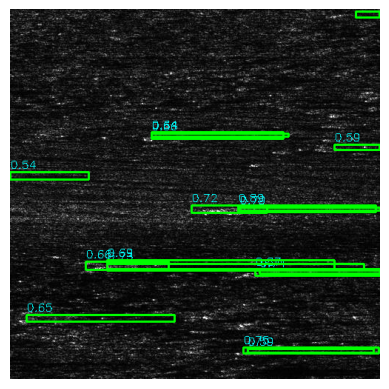

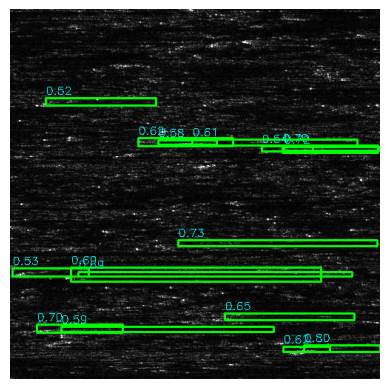

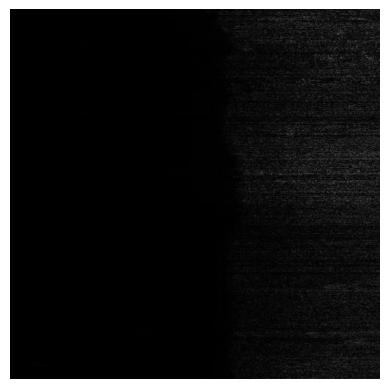

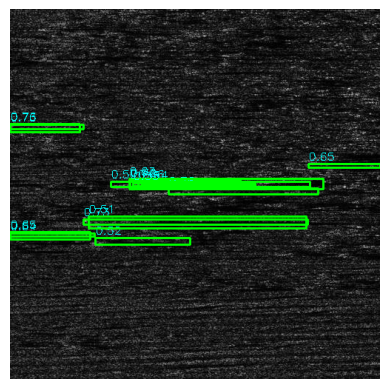

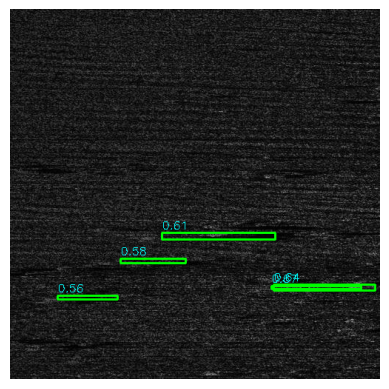

In [ ]:
visualize(model, "/content/drive/MyDrive/sonar-object-detection/data/line2voc", num_images=5)

## **inference_and_visualization.py**

In [21]:
# batch inference for the raw model (baseline trained on original sonar data)

import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from voc_dataset import VOCDataset

# set paths for raw images and model
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis"
PRED_CSV = PROJECT_ROOT / "outputs" / "preds.csv"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "baseline_sonar_fasterrcnn.pth"

# create folders if needed
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the baseline model
model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# collect all predictions here
all_preds = []

# loop through all raw sonar images
for img_path in IMG_DIR.glob("*.jpg"):
    image_pil = Image.open(img_path).convert("RGB")
    image_tensor = ToTensor()(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)[0]

    boxes = output["boxes"].cpu()
    scores = output["scores"].cpu()
    labels = output["labels"].cpu()

    # convert to OpenCV format so I can draw boxes
    img_np = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

    for i in range(len(boxes)):
        score = scores[i].item()
        if score < 0.5:
            continue  # skip low-confidence boxes

        x1, y1, x2, y2 = boxes[i].int().tolist()
        class_id = labels[i].item()

        # store in CSV output
        all_preds.append({
            "filename": img_path.name,
            "class_id": class_id,
            "score": score,
            "xmin": x1,
            "ymin": y1,
            "xmax": x2,
            "ymax": y2,
        })

        # draw box on image
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    # save annotated image
    out_path = OUTPUT_DIR / img_path.name
    cv2.imwrite(str(out_path), img_np)

# save predictions to CSV
df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print(f"Inference complete. Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Inference complete. Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/vis
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds.csv


# **Install TorchMetrics**

In [16]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

## **evaluate_model.py**

In [ ]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, dataset_root, batch_size=4, image_set="val"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision()

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            preds = []
            targs = []
            for o, t in zip(outputs, targets):
                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                targs.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            metric.update(preds, targs)

    results = metric.compute()
    print("Evaluation Results:")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

In [ ]:
evaluate(model, "/content/drive/MyDrive/sonar-object-detection/data/line2voc")

Evaluation Results:
map: 0.0441
map_50: 0.1643
map_75: 0.0109
map_small: 0.0299
map_medium: 0.0774
map_large: 0.1182
mar_1: 0.0141
mar_10: 0.0687
mar_100: 0.1623
mar_small: 0.1242
mar_medium: 0.2482
mar_large: 0.2286
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: 1.0000


## **Load Faster R-CNN and Start Training with Preprocessed Data**

## **train_denoised_fasterrcnn.py**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# allow importing my custom dataset class
import sys
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# path to the preprocessed (denoised) dataset
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"

# apply basic transform
transform = T.ToTensor()

# load the train and val sets
train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# use pretrained COCO weights (this replaces the old "pretrained=True")
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

# update the classification head to match my dataset (2 object classes + background)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# set optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# train for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in tqdm(train_loader):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

# make sure the checkpoints folder exists before saving
checkpoint_dir = "/content/drive/MyDrive/sonar-object-detection/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# save the trained model
torch.save(model.state_dict(), os.path.join(checkpoint_dir, "denoised_fasterrcnn.pth"))


100%|██████████| 626/626 [00:55<00:00, 11.23it/s]


Epoch 1, Loss: 726.7467


100%|██████████| 626/626 [00:55<00:00, 11.28it/s]


Epoch 2, Loss: 676.0123


100%|██████████| 626/626 [00:55<00:00, 11.31it/s]


Epoch 3, Loss: 650.2362


100%|██████████| 626/626 [00:55<00:00, 11.22it/s]


Epoch 4, Loss: 639.4794


100%|██████████| 626/626 [00:55<00:00, 11.27it/s]


Epoch 5, Loss: 631.9655


## **evaluate_denoised_model.py**

In [17]:
# evaluate_denoised_model.py
# Evaluate the Faster R-CNN trained on denoised sonar data

import sys
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(weights=None)

# Adjust head for 3 classes
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load trained weights from denoised model
model.load_state_dict(torch.load("/content/drive/MyDrive/sonar-object-detection/checkpoints/denoised_fasterrcnn.pth", map_location=device))

# Evaluate on validation set from preprocessed dataset
def evaluate(model, dataset_root, batch_size=4, image_set="val"):
    model.eval()
    model.to(device)

    dataset = VOCDataset(dataset_root, image_set=image_set, transforms=ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision()

    with torch.no_grad():
        for imgs, targets in loader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            preds = []
            targs = []
            for o, t in zip(outputs, targets):
                preds.append({
                    "boxes": o["boxes"].cpu(),
                    "scores": o["scores"].cpu(),
                    "labels": o["labels"].cpu()
                })
                targs.append({
                    "boxes": t["boxes"].cpu(),
                    "labels": t["labels"].cpu()
                })

            metric.update(preds, targs)

    results = metric.compute()
    print("Evaluation Results (Denoised Model):")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

# Run evaluation on denoised dataset
evaluate(model, "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Evaluation Results (Denoised Model):
map: 0.0475
map_50: 0.1693
map_75: 0.0143
map_small: 0.0352
map_medium: 0.0701
map_large: 0.0257
mar_1: 0.0137
mar_10: 0.0728
mar_100: 0.1677
mar_small: 0.1311
mar_medium: 0.2522
mar_large: 0.0250
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: 1.0000


## **visualize_predictions_denoised.py**

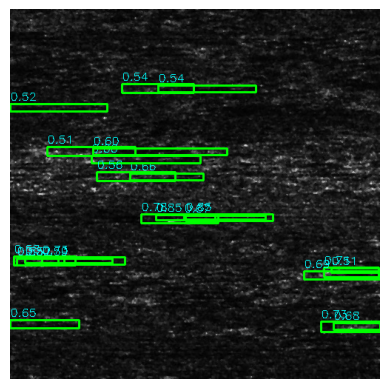

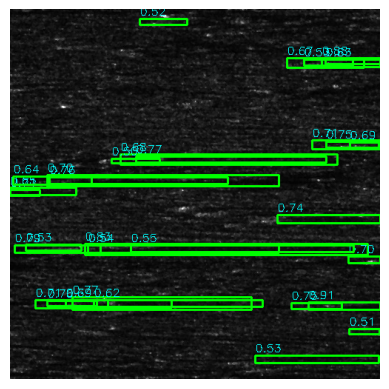

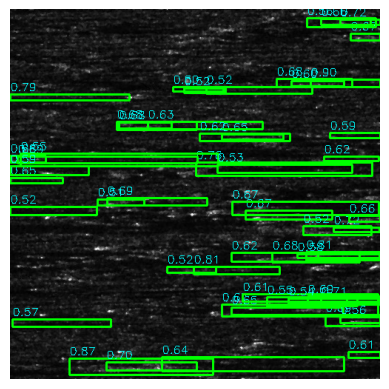

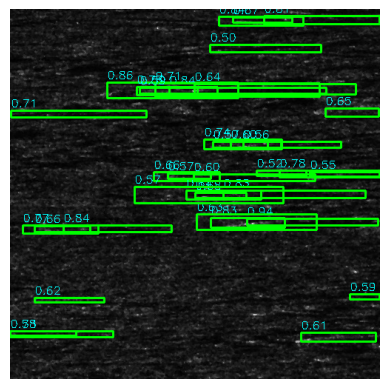

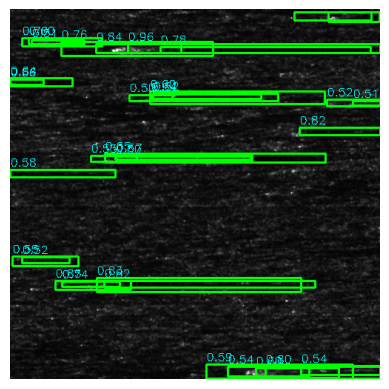

In [18]:
# visualize predictions from the denoised model

from voc_dataset import VOCDataset
from torchvision.transforms import ToTensor
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# set paths
MODEL_PATH = "/content/drive/MyDrive/sonar-object-detection/checkpoints/denoised_fasterrcnn.pth"
DATASET_ROOT = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed"

# load model
model = fasterrcnn_resnet50_fpn(weights=None)
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# load validation set
dataset = VOCDataset(DATASET_ROOT, image_set="val", transforms=ToTensor())

# visualize a few predictions
for i in range(5):
    img, _ = dataset[i]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    img_np = img.mul(255).byte().permute(1, 2, 0).cpu().numpy()
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR).copy()

    for box, score in zip(output["boxes"], output["scores"]):
        if score < 0.5:
            continue
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

## **inference_and_visualization_denoised.py**

In [19]:
# run batch inference using my denoised model and save results

import os
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from voc_dataset import VOCDataset

# set base project path (mounted from Drive)
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")

# use the preprocessed image folder
IMG_DIR = PROJECT_ROOT / "data" / "line2voc_preprocessed" / "JPEGImages"

# save outputs here
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_denoised"
PRED_CSV = PROJECT_ROOT / "outputs" / "preds_denoised.csv"

# load the trained model
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "denoised_fasterrcnn.pth"

# create output folders if missing
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PRED_CSV.parent.mkdir(parents=True, exist_ok=True)

# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model structure and my trained weights
model = fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# hold all predictions here
all_preds = []

# loop through all images in validation set
for img_path in IMG_DIR.glob("*.jpg"):
    image_pil = Image.open(img_path).convert("RGB")
    image_tensor = ToTensor()(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)[0]

    boxes = output["boxes"].cpu()
    scores = output["scores"].cpu()
    labels = output["labels"].cpu()

    # convert image to OpenCV format for drawing
    img_np = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

    for i in range(len(boxes)):
        score = scores[i].item()
        if score < 0.5:
            continue  # skip low confidence boxes

        x1, y1, x2, y2 = boxes[i].int().tolist()
        class_id = labels[i].item()

        # store prediction
        all_preds.append({
            "filename": img_path.name,
            "class_id": class_id,
            "score": score,
            "xmin": x1,
            "ymin": y1,
            "xmax": x2,
            "ymax": y2,
        })

        # draw box + score on image
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    # save visual output
    out_path = OUTPUT_DIR / img_path.name
    cv2.imwrite(str(out_path), img_np)

# save prediction results to CSV
df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print(f"Inference complete. Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Inference complete. Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/vis_denoised
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_denoised.csv


## **preprocess_with_clahe_and_aug.py**

In [23]:
# scripts/preprocess_with_clahe_and_aug.py
# Apply median blur + CLAHE + augmentations to sonar images
# and save structured VOC dataset to new folder

from pathlib import Path
import cv2, os, shutil, random, numpy as np

# Set project paths (for Colab)
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
SRC_IMG_DIR = PROJECT_ROOT / "data" / "line2voc" / "JPEGImages"
SRC_ANN_DIR = PROJECT_ROOT / "data" / "line2voc" / "Annotations"
SRC_SPLIT_DIR = PROJECT_ROOT / "data" / "line2voc" / "ImageSets" / "Main"
DEST_ROOT = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented"
DEST_IMG_DIR = DEST_ROOT / "JPEGImages"
DEST_ANN_DIR = DEST_ROOT / "Annotations"
DEST_SPLIT_DIR = DEST_ROOT / "ImageSets" / "Main"

DEST_IMG_DIR.mkdir(parents=True, exist_ok=True)
DEST_ANN_DIR.mkdir(parents=True, exist_ok=True)
DEST_SPLIT_DIR.mkdir(parents=True, exist_ok=True)

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((cl, a, b)), cv2.COLOR_LAB2BGR)

def apply_augmentations(img):
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
    angle = random.uniform(-10, 10)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT101)
    brightness = random.uniform(0.9, 1.1)
    contrast = random.uniform(0.9, 1.1)
    img = np.clip(contrast * img + brightness * 10, 0, 255).astype(np.uint8)
    return img

# Apply median → CLAHE → Augmentation
count = 0
for img_path in SRC_IMG_DIR.glob("*.jpg"):
    img = cv2.imread(str(img_path))
    if img is None:
        continue
    img = cv2.medianBlur(img, 3)
    img = apply_clahe(img)
    img = apply_augmentations(img)
    out_path = DEST_IMG_DIR / img_path.name
    cv2.imwrite(str(out_path), img)
    count += 1

print(f"{count} images processed and saved to: {DEST_IMG_DIR}")

# Copy annotations and splits
for xml in SRC_ANN_DIR.glob("*.xml"):
    shutil.copy(xml, DEST_ANN_DIR)
for split in SRC_SPLIT_DIR.glob("*.txt"):
    shutil.copy(split, DEST_SPLIT_DIR)

print("Annotations and split files copied.")

1788 images processed and saved to: /content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented/JPEGImages
Annotations and split files copied.


## **train_augmented_fasterrcnn.py**

In [27]:
# train Faster R-CNN on CLAHE + augmented sonar images (Colab version)

import sys
import os
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# allow importing my custom dataset class
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

# dataset path (this one was denoised + enhanced + augmented offline)
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented"

# just normalize and convert to tensor
transform = T.ToTensor()

# load train and val splits
train_dataset = VOCDataset(DATASET_DIR, image_set="train", transforms=transform)
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# load model with pretrained weights
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features

# change head for 2 object classes + background
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4)

# training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

# save model
SAVE_PATH = "/content/drive/MyDrive/sonar-object-detection/checkpoints/augmented_fasterrcnn.pth"
torch.save(model.state_dict(), SAVE_PATH)
print(f"Model saved to: {SAVE_PATH}")

Epoch 1: 100%|██████████| 626/626 [00:57<00:00, 10.95it/s]


Epoch 1, Loss: 705.6884


Epoch 2: 100%|██████████| 626/626 [00:56<00:00, 10.99it/s]


Epoch 2, Loss: 687.8913


Epoch 3: 100%|██████████| 626/626 [00:56<00:00, 11.03it/s]


Epoch 3, Loss: 682.7025


Epoch 4: 100%|██████████| 626/626 [00:57<00:00, 10.94it/s]


Epoch 4, Loss: 676.0244


Epoch 5: 100%|██████████| 626/626 [00:57<00:00, 10.94it/s]


Epoch 5, Loss: 674.8722
Model saved to: /content/drive/MyDrive/sonar-object-detection/checkpoints/augmented_fasterrcnn.pth


## **evaluate_augmented_model.py**

In [29]:
# evaluate Faster R-CNN model trained on CLAHE + augmented sonar images

import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# import my dataset class
import sys
sys.path.append('/content/drive/MyDrive/sonar-object-detection/scripts')
from voc_dataset import VOCDataset

# load the trained model
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)

# load model weights
checkpoint_path = "/content/drive/MyDrive/sonar-object-detection/checkpoints/augmented_fasterrcnn.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# setup validation data (same split used before)
DATASET_DIR = "/content/drive/MyDrive/sonar-object-detection/data/line2voc_preprocessed_augmented"
transform = T.ToTensor()
val_dataset = VOCDataset(DATASET_DIR, image_set="val", transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# init metric tracker
metric = MeanAveragePrecision()

# run evaluation
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(imgs)

        preds = [{
            "boxes": o["boxes"].cpu(),
            "scores": o["scores"].cpu(),
            "labels": o["labels"].cpu()
        } for o in outputs]

        targs = [{
            "boxes": t["boxes"].cpu(),
            "labels": t["labels"].cpu()
        } for t in targets]

        metric.update(preds, targs)

# print the results
results = metric.compute()
print("Evaluation Results (Augmented Model):")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Evaluation Results (Augmented Model):
map: 0.0026
map_50: 0.0084
map_75: 0.0009
map_small: 0.0005
map_medium: 0.0042
map_large: 0.0024
mar_1: 0.0008
mar_10: 0.0073
mar_100: 0.0272
mar_small: 0.0063
mar_medium: 0.0742
mar_large: 0.0714
map_per_class: -1.0000
mar_100_per_class: -1.0000
classes: 1.0000


## **visualize_predictions_augmented.py**

In [30]:
# visualize predictions from Faster R-CNN model trained on augmented sonar data

import os
import cv2
import torch
import numpy as np
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# use full path to the dataset and model
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented" / "JPEGImages"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "augmented_fasterrcnn.pth"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_augmented"

# make sure output folder exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# run inference on a few images
transform = ToTensor()
img_paths = list(IMG_DIR.glob("*.jpg"))[:5]

for img_path in img_paths:
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    boxes = output["boxes"].cpu()
    scores = output["scores"].cpu()
    labels = output["labels"].cpu()

    # convert image back to OpenCV format
    img_np = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for i in range(len(boxes)):
        score = scores[i].item()
        if score < 0.5:
            continue

        x1, y1, x2, y2 = boxes[i].int().tolist()
        class_id = labels[i].item()

        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    out_path = OUTPUT_DIR / img_path.name
    cv2.imwrite(str(out_path), img_np)

print(f"Saved predictions to: {OUTPUT_DIR}")

Saved predictions to: /content/drive/MyDrive/sonar-object-detection/outputs/vis_augmented


## **inference_and_visualization_augmented.py**

In [31]:
# run batch inference on augmented sonar dataset and save predictions + visuals

import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# project paths
PROJECT_ROOT = Path("/content/drive/MyDrive/sonar-object-detection")
IMG_DIR = PROJECT_ROOT / "data" / "line2voc_preprocessed_augmented" / "JPEGImages"
MODEL_PATH = PROJECT_ROOT / "checkpoints" / "augmented_fasterrcnn.pth"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "vis_augmented"
PRED_CSV = PROJECT_ROOT / "outputs" / "preds_augmented.csv"

# make sure output folders exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load model
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# prediction storage
all_preds = []

# run inference
transform = ToTensor()
for img_path in IMG_DIR.glob("*.jpg"):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)[0]

    boxes = output["boxes"].cpu()
    scores = output["scores"].cpu()
    labels = output["labels"].cpu()

    # convert back to OpenCV
    img_np = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for i in range(len(boxes)):
        score = scores[i].item()
        if score < 0.5:
            continue

        x1, y1, x2, y2 = boxes[i].int().tolist()
        class_id = labels[i].item()

        # save box info
        all_preds.append({
            "filename": img_path.name,
            "class_id": class_id,
            "score": score,
            "xmin": x1,
            "ymin": y1,
            "xmax": x2,
            "ymax": y2,
        })

        # draw
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_np, f"{score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    out_path = OUTPUT_DIR / img_path.name
    cv2.imwrite(str(out_path), img_np)

# save preds
df = pd.DataFrame(all_preds)
df.to_csv(PRED_CSV, index=False)

print(f"Visuals saved to: {OUTPUT_DIR}")
print(f"Predictions saved to: {PRED_CSV}")

Visuals saved to: /content/drive/MyDrive/sonar-object-detection/outputs/vis_augmented
Predictions saved to: /content/drive/MyDrive/sonar-object-detection/outputs/preds_augmented.csv
